In [294]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [330]:
#Dir path
Case='NorthDakota'
#Case='Colorado'
#Case='Idaho'
crop='Potatoes'

start_y=2008
end_y=2023

sites_pth = 'Data/'+Case+'/sites/'
cdl_pth = 'Data/'+Case+'/cdl/'
season_pth = 'Data/'+Case+'/season/'

site_names = os.listdir(sites_pth)
cdl_names = os.listdir(cdl_pth)
season_names = os.listdir(season_pth)
location=np.load('Data/'+Case+'/masklayers/wgscenterlist.npy')
num_sites=len(site_names)
#Load the data
timelog=pd.read_hdf('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Event_log/log_'+Case+'_240524_max09_df.h5')

In [331]:
crop_encod_temp=timelog['Crop']
sorted_crop=np.unique(timelog['Crop'])[np.argsort(np.unique(timelog['Crop'], return_counts=True)[1])[::-1]]
crop_encod=[int(np.where(sorted_crop==value)[0][0]) for value in crop_encod_temp]#sorted_crop.index(value)
timelog['CropID']=crop_encod

In [297]:
sorted_crop

array(['Spring Wheat', 'Dry Beans', 'Potatoes', 'Sugarbeets', 'Soybeans',
       'Durum Wheat', '', 'Corn', 'Sorghum', 'Canola',
       'Fallow/Idle Cropland', 'Winter Wheat', 'Speltz', 'Sunflower',
       'Barley', 'Alfalfa', 'Grassland/Pasture'], dtype=object)

In [298]:
np.sort(np.unique(timelog['Crop'], return_counts=True)[1])[::-1]

array([4068, 2204, 1912, 1372, 1116,  412,  324,  292,  184,   32,   24,
          8,    8,    4,    4,    4,    4], dtype=int64)

In [332]:
#Remove multiple crop cases
timelog=timelog[timelog['Multiple_crop'] == 0]
#subset crop
timelog=timelog[timelog['Crop'] == crop]
#timelog=timelog[timelog['CropID'] < 4]


In [333]:
timelog['DayOfYear'] = timelog['Timestamp'].dt.dayofyear

In [334]:
TimeLST=[]
NdviLST=[]
CropLST=[]
for i,e in enumerate(['Emergence','Maturity','Senescence','Dormancy']):
    TimeLST.append(timelog[timelog['Activity'] == e]['DayOfYear'].values)
    NdviLST.append(timelog[timelog['Activity'] == e]['NDVI_range'].values)
    CropLST.append(timelog[timelog['Activity'] == e]['Crop'].values)

In [335]:
NdviLST[0]=np.array([np.min(n) for n in NdviLST[0]])
NdviLST[1]=np.array([np.max(n) for n in NdviLST[1]])
NdviLST[2]=np.array([np.max(n) for n in NdviLST[2]])
NdviLST[3]=np.array([np.min(n) for n in NdviLST[3]])

In [336]:
kf = KFold(n_splits=5, random_state=27, shuffle=False)
kf.get_n_splits(X)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [357]:
data = {
    't1': TimeLST[0]-np.mean(TimeLST[1]),
    't2': TimeLST[1]-np.mean(TimeLST[2]),
    't3': TimeLST[2]-np.mean(TimeLST[3]),
    'n1': NdviLST[0]-np.mean(NdviLST[0]),
    'n2': NdviLST[1]-np.mean(NdviLST[1]),
    'n3': NdviLST[2]-np.mean(NdviLST[2]),
    'n4': NdviLST[3]-np.mean(NdviLST[3]),
    't4': (TimeLST[3]-np.mean(TimeLST[3])),
    'l1': TimeLST[1]-TimeLST[0],
    'l2': TimeLST[2]-TimeLST[1],
    'l3': TimeLST[2]-TimeLST[0],
    'cp': CropLST[0]
}
data = {
    't1': TimeLST[0],
    't2': TimeLST[1],
    't3': TimeLST[2],
    'n1': NdviLST[0],
    'n2': NdviLST[1],
    'n3': NdviLST[2],
    'nl1': NdviLST[1]-NdviLST[0],
    'nl2': NdviLST[2]-NdviLST[1],
    'nl3': NdviLST[2]-NdviLST[0],
    'n4': NdviLST[3],
    't4': (TimeLST[3]),
    'tl4': TimeLST[3]-TimeLST[0],#how long it takes from sen to dor
    'l1': TimeLST[1]-TimeLST[0],
    'l2': TimeLST[2]-TimeLST[1],
    'l3': TimeLST[2]-TimeLST[0],
    'cp': CropLST[0]
}
df = pd.DataFrame(data)
#X = df[['t1', 't2', 't3', 'n1', 'n2', 'n3', 'nl1','nl2', 'nl3','l1', 'l2','l3']]
X = df[['t1', 'n1', 'nl1','nl2', 'nl3','l1', 'l2','l3']]#by far the best score 0.38 with n = 20. tl4 = lst 3-0
#X = df[['t1', 't2', 't3', 'n1', 'n2', 'n3','l1', 'l2']]#by far the best score 0.25-0.3
#X = df[['t3','n3', 'l2']]
y = df['tl4']
#y = df['l3']

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=27)
encoder_one_hot = OneHotEncoder()
#x_train = encoder_one_hot.fit_transform(x_train[['cp']])
#x_test = encoder_one_hot.transform(x_test[['cp']])

print(len(y_train),len(y_test))

329 37


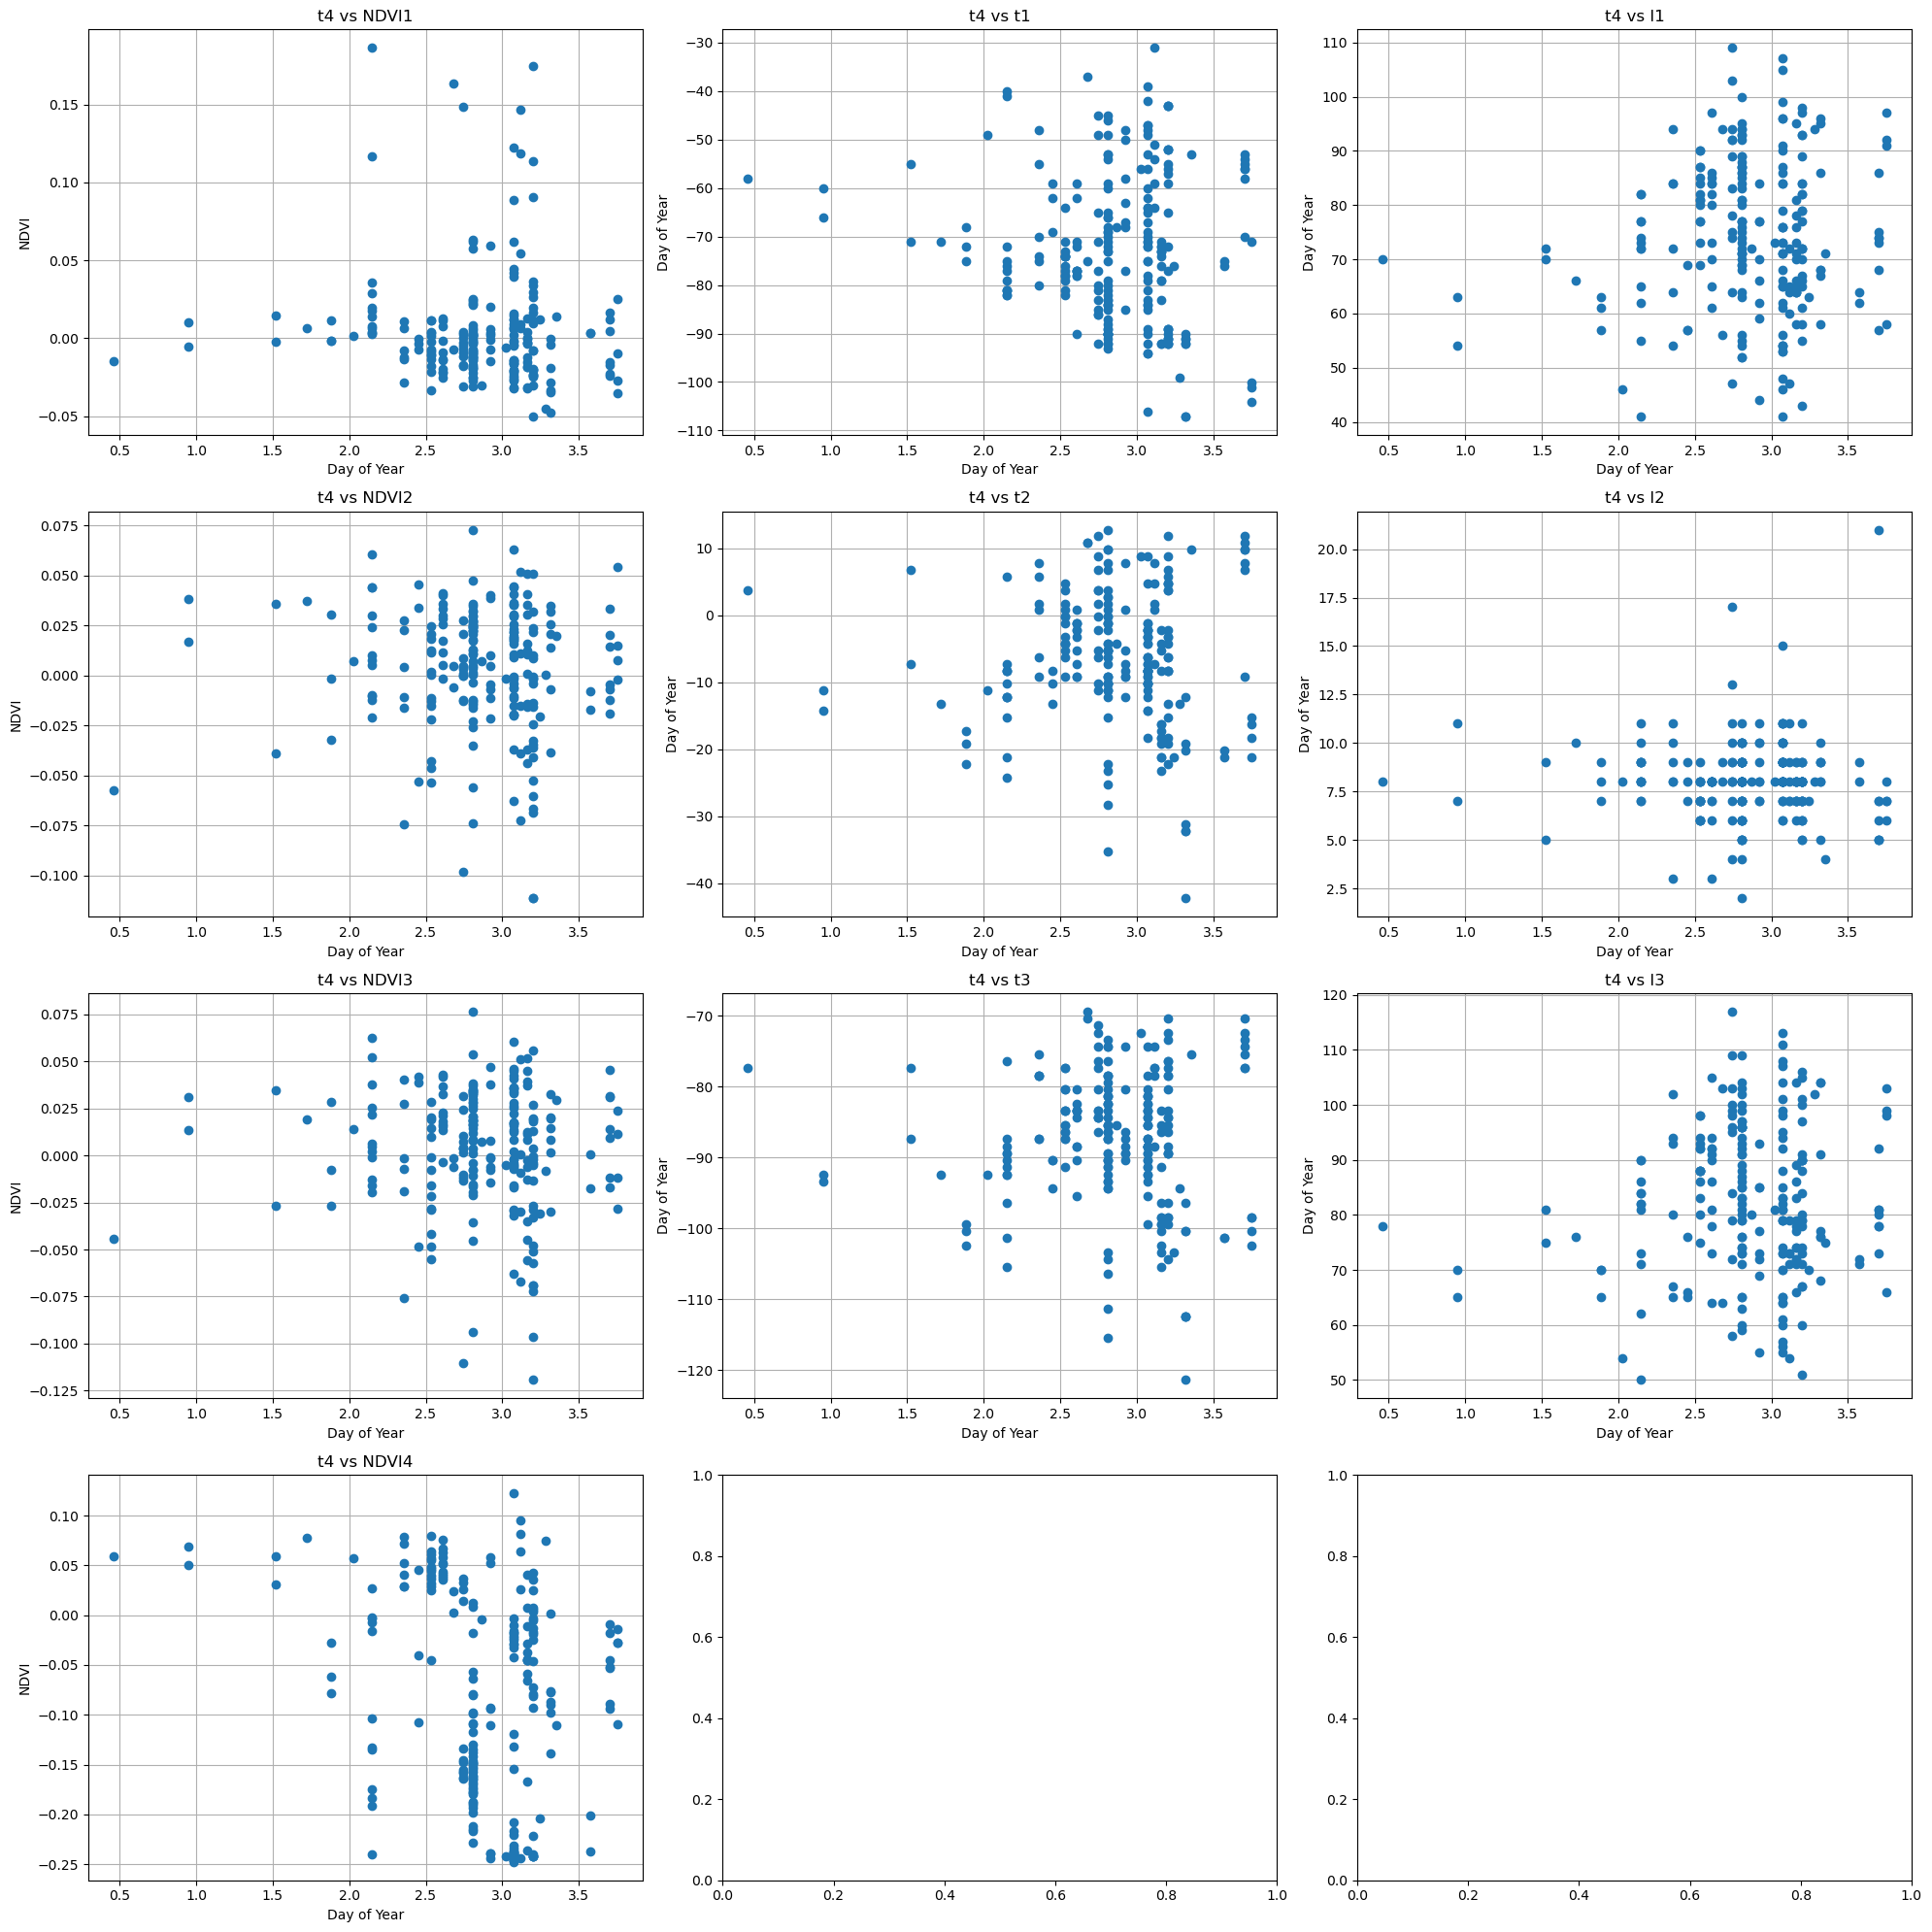

In [257]:
fig,ax=plt.subplots(4, 3, figsize=(20, 20))
#ax=ax.ravel()

ax[0,0].plot((df['t4']),(df['n1']),'o')
ax[0,0].set_ylabel('NDVI')
ax[0,0].set_xlabel('Day of Year')
ax[0,0].set_title('t4 vs NDVI1')
ax[0,0].grid()


ax[1,0].plot((df['t4']),(df['n2']),'o')
ax[1,0].set_ylabel('NDVI')
ax[1,0].set_xlabel('Day of Year')
ax[1,0].set_title('t4 vs NDVI2')
ax[1,0].grid()

ax[2,0].plot((df['t4']),(df['n3']),'o')
ax[2,0].set_ylabel('NDVI')
ax[2,0].set_xlabel('Day of Year')
ax[2,0].set_title('t4 vs NDVI3')
ax[2,0].grid()

ax[3,0].plot(df['t4'],df['n4'],'o')
ax[3,0].set_ylabel('NDVI')
ax[3,0].set_xlabel('Day of Year')
ax[3,0].set_title('t4 vs NDVI4')
ax[3,0].grid()

ax[0,1].plot((df['t4']),(df['t1']),'o')
ax[0,1].set_ylabel('Day of Year')
ax[0,1].set_xlabel('Day of Year')
ax[0,1].set_title('t4 vs t1')
ax[0,1].grid()


ax[1,1].plot((df['t4']),(df['t2']),'o')
ax[1,1].set_ylabel('Day of Year')
ax[1,1].set_xlabel('Day of Year')
ax[1,1].set_title('t4 vs t2')
ax[1,1].grid()

ax[2,1].plot((df['t4']),(df['t3']),'o')
ax[2,1].set_ylabel('Day of Year')
ax[2,1].set_xlabel('Day of Year')
ax[2,1].set_title('t4 vs t3')
ax[2,1].grid()

ax[0,2].plot((df['t4']),(df['l1']),'o')
ax[0,2].set_ylabel('Day of Year')
ax[0,2].set_xlabel('Day of Year')
ax[0,2].set_title('t4 vs l1')
ax[0,2].grid()


ax[1,2].plot((df['t4']),(df['l2']),'o')
ax[1,2].set_ylabel('Day of Year')
ax[1,2].set_xlabel('Day of Year')
ax[1,2].set_title('t4 vs l2')
ax[1,2].grid()

ax[2,2].plot((df['t4']),(df['l3']),'o')
ax[2,2].set_ylabel('Day of Year')
ax[2,2].set_xlabel('Day of Year')
ax[2,2].set_title('t4 vs l3')
ax[2,2].grid()
plt.tight_layout()

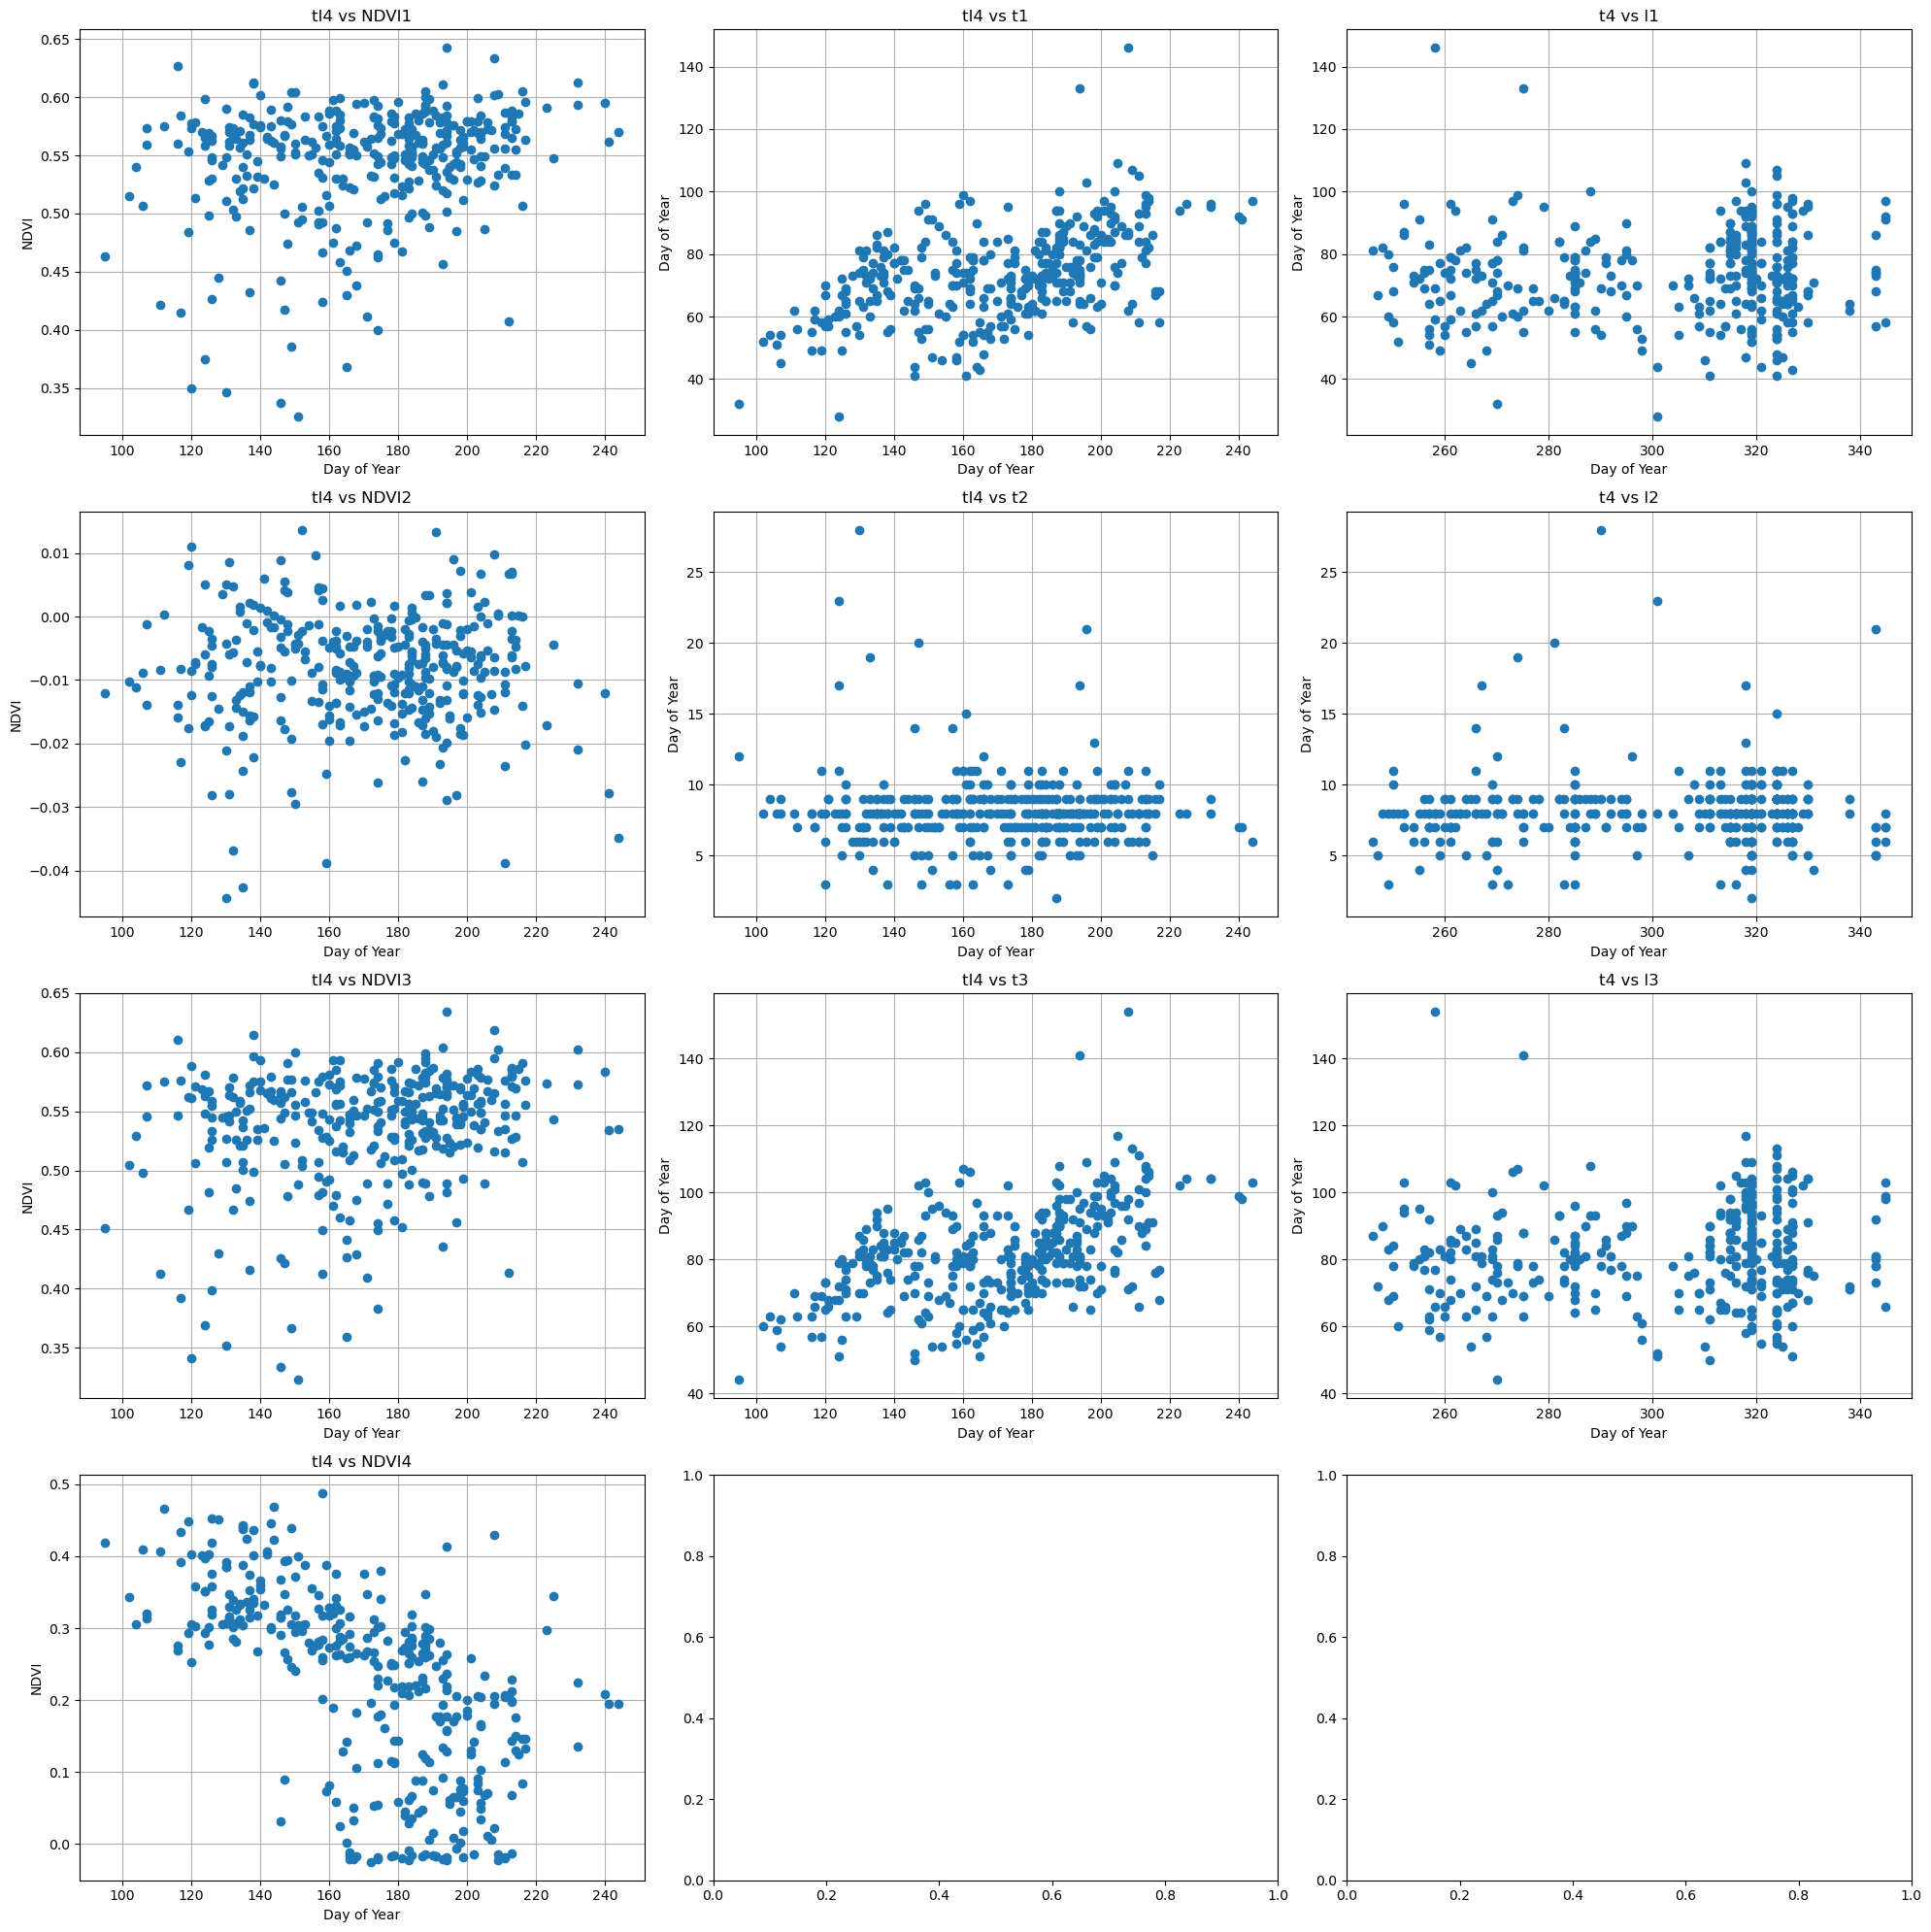

In [343]:
fig,ax=plt.subplots(4, 3, figsize=(20, 20))
#ax=ax.ravel()

ax[0,0].plot((df['tl4']),(df['nl1']),'o')
ax[0,0].set_ylabel('NDVI')
ax[0,0].set_xlabel('Day of Year')
ax[0,0].set_title('tl4 vs NDVI1')
ax[0,0].grid()


ax[1,0].plot((df['tl4']),(df['nl2']),'o')
ax[1,0].set_ylabel('NDVI')
ax[1,0].set_xlabel('Day of Year')
ax[1,0].set_title('tl4 vs NDVI2')
ax[1,0].grid()

ax[2,0].plot((df['tl4']),(df['nl3']),'o')
ax[2,0].set_ylabel('NDVI')
ax[2,0].set_xlabel('Day of Year')
ax[2,0].set_title('tl4 vs NDVI3')
ax[2,0].grid()

ax[3,0].plot(df['tl4'],df['n4'],'o')
ax[3,0].set_ylabel('NDVI')
ax[3,0].set_xlabel('Day of Year')
ax[3,0].set_title('tl4 vs NDVI4')
ax[3,0].grid()

ax[0,1].plot((df['tl4']),(df['l1']),'o')
ax[0,1].set_ylabel('Day of Year')
ax[0,1].set_xlabel('Day of Year')
ax[0,1].set_title('tl4 vs t1')
ax[0,1].grid()


ax[1,1].plot((df['tl4']),(df['l2']),'o')
ax[1,1].set_ylabel('Day of Year')
ax[1,1].set_xlabel('Day of Year')
ax[1,1].set_title('tl4 vs t2')
ax[1,1].grid()

ax[2,1].plot((df['tl4']),(df['l3']),'o')
ax[2,1].set_ylabel('Day of Year')
ax[2,1].set_xlabel('Day of Year')
ax[2,1].set_title('tl4 vs t3')
ax[2,1].grid()

ax[0,2].plot((df['t4']),(df['l1']),'o')
ax[0,2].set_ylabel('Day of Year')
ax[0,2].set_xlabel('Day of Year')
ax[0,2].set_title('t4 vs l1')
ax[0,2].grid()


ax[1,2].plot((df['t4']),(df['l2']),'o')
ax[1,2].set_ylabel('Day of Year')
ax[1,2].set_xlabel('Day of Year')
ax[1,2].set_title('t4 vs l2')
ax[1,2].grid()

ax[2,2].plot((df['t4']),(df['l3']),'o')
ax[2,2].set_ylabel('Day of Year')
ax[2,2].set_xlabel('Day of Year')
ax[2,2].set_title('t4 vs l3')
ax[2,2].grid()
plt.tight_layout()

In [344]:
print(df.corr())


           t1        t2        t3        n1       nl1       nl2       nl3  \
t1   1.000000  0.465385  0.495750  0.705346 -0.493954  0.039007 -0.480183   
t2   0.465385  1.000000  0.967261  0.246570 -0.214441  0.096599 -0.194311   
t3   0.495750  0.967261  1.000000  0.296126 -0.259974  0.085883 -0.241117   
n1   0.705346  0.246570  0.296126  1.000000 -0.708383 -0.002074 -0.698938   
nl1 -0.493954 -0.214441 -0.259974 -0.708383  1.000000 -0.011533  0.984098   
nl2  0.039007  0.096599  0.085883 -0.002074 -0.011533  1.000000  0.166263   
nl3 -0.480183 -0.194311 -0.241117 -0.698938  0.984098  0.166263  1.000000   
n4  -0.083090 -0.148212 -0.151004 -0.099033 -0.046132 -0.026305 -0.050165   
t4   0.100522  0.270001  0.274037  0.137758 -0.045851  0.025942 -0.040608   
tl4 -0.459486 -0.014569 -0.027643 -0.264414  0.230359  0.001735  0.227476   
l1  -0.794354  0.167984  0.111695 -0.616356  0.402970  0.022852  0.401447   
l2   0.111756 -0.142051  0.113810  0.189748 -0.174520 -0.043184 -0.179773   

C:\Users\Vito\AppData\Local\Temp\ipykernel_3212\308504422.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())


In [345]:
print(df.cov())

             t1         t2         t3            n1       nl1           nl2  \
t1   257.022023  73.707643  78.228984  4.084501e-01 -0.385174  5.478978e-03   
t2    73.707643  97.595636  94.054286  8.798488e-02 -0.103040  8.361023e-03   
t3    78.228984  94.054286  96.881174  1.052806e-01 -0.124461  7.406245e-03   
n1     0.408450   0.087985   0.105281  1.304679e-03 -0.001245 -6.563144e-07   
nl1   -0.385174  -0.103040  -0.124461 -1.244528e-03  0.002366 -4.914598e-06   
nl2    0.005479   0.008361   0.007406 -6.563144e-07 -0.000005  7.676219e-05   
nl3   -0.379695  -0.094679  -0.117055 -1.245184e-03  0.002361  7.184760e-05   
n4    -0.174436  -0.191734  -0.194630 -4.684179e-04 -0.000294 -3.017985e-05   
t4    41.994341  69.506468  70.286908  1.296628e-01 -0.058114  5.922626e-03   
tl4 -215.027682  -4.201175  -7.942077 -2.787873e-01  0.327060  4.436482e-04   
l1  -183.314380  23.887993  15.825301 -3.204652e-01  0.282134  2.882045e-03   
l2     4.521341  -3.541350   2.826888  1.729574e-02 

C:\Users\Vito\AppData\Local\Temp\ipykernel_3212\615776904.py:1: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.cov())


C:\Users\Vito\AppData\Local\Temp\ipykernel_3212\1635920665.py:1: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.cov())


<Axes: >

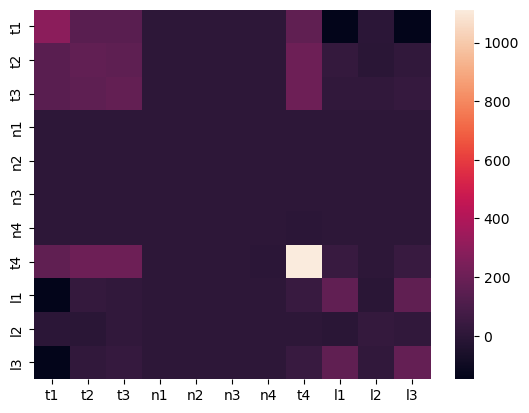

In [310]:
sns.heatmap(df.cov())

C:\Users\Vito\AppData\Local\Temp\ipykernel_3212\58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

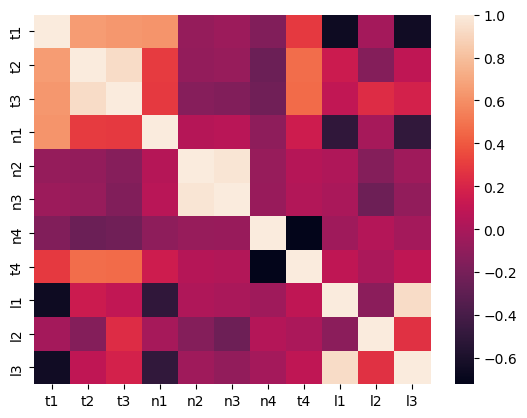

In [311]:
sns.heatmap(df.corr())

In [249]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm

# Calculate VIF for each feature
X_with_const = sm.tools.tools.add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = X_with_const.columns
vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif)

  Variable        VIF
0    const   0.000000
1       t1        inf
2       t2        inf
3       t3        inf
4       n1   2.063877
5       n2  16.455926
6       n3  16.428421
7       l1        inf
8       l2        inf
9       l3        inf


c:\Users\Vito\miniconda3\envs\gee\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\Vito\miniconda3\envs\gee\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [353]:
r2_scores = []
mae_scores = []
for n in range(10,100):
    model = RandomForestRegressor(n_estimators=n, random_state=27)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)
    #print(f'Number of Trees: {n}')
    #print(f'Mean Absolute Error: {mae}')
    #print(f'R^2 Score: {r2}')


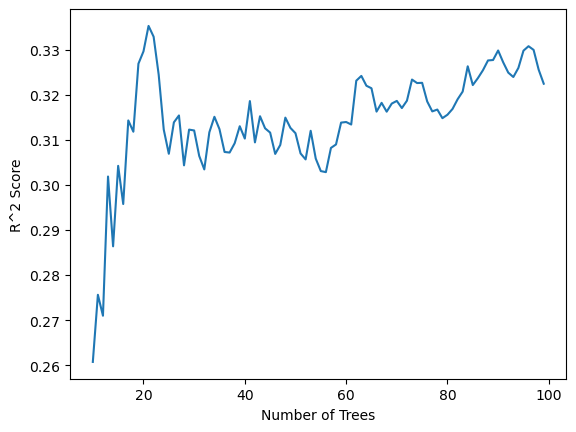

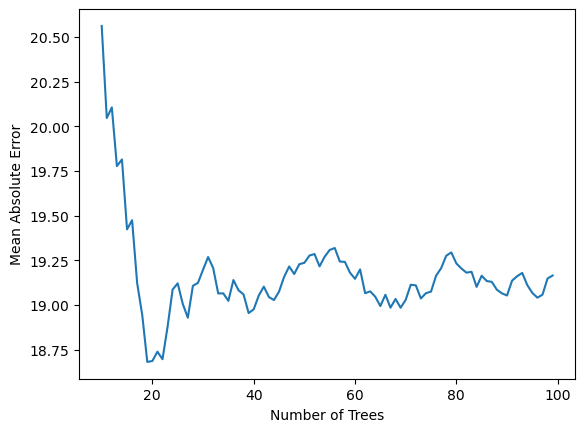

In [354]:
plt.plot(range(10, 100), r2_scores)
plt.xlabel('Number of Trees')
plt.ylabel('R^2 Score')
plt.show()

plt.plot(range(10,100), mae_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Mean Absolute Error')
plt.show()

In [361]:
model = RandomForestRegressor(n_estimators=20, random_state=27)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(r2)
print(mae)

0.3815065204377939
18.260810810810813


In [359]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(r2)
print(mae)

0.358242172538616
19.935732940332226


In [264]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=0.9)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(r2)
print(mae)

0.0970857144861067
20.57543745201074


In [233]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2  # Degree of the polynomial
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(r2)
print(mae)

0.028785012067516047
20.116832941547752


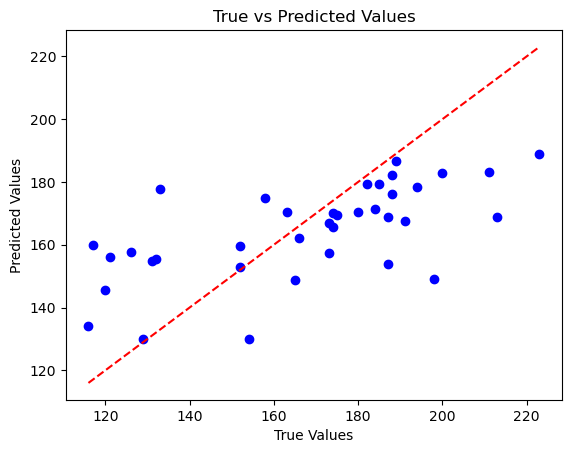

In [362]:
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()